# td-idf classification (JV)

Classification of publication day of week based on Term Frequency — Inverse Document Frequency (tf-idf) analysis

## Packages

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Training Data

For the Bag-of-Words and td-idf analysis, each document in the training data set is a concatenation of all of the hints for a particular puzzle, for a total of 9757 puzzles in the corpus.

In [2]:
xword_full = pd.read_csv('jv-xword-full.csv', converters={'Answer' : str, 'Hint' : str}, parse_dates = ['date'])

In [3]:
hints_per_puzzle = xword_full.groupby(['date'])['Hint'].agg(list).reset_index()
hints_per_puzzle['WeekdayNum'] = hints_per_puzzle['date'].dt.dayofweek
hints_per_puzzle['hints_joined'] = hints_per_puzzle['Hint'].apply(lambda x: " ".join(x))

hints_per_puzzle.sample(5)

,date,Hint,WeekdayNum,hints_joined
7253,2014-02-18,"[*Everything, ""Yo mama"" joke; e.g., Hopeless c...",1,"*Everything ""Yo mama"" joke; e.g. Hopeless case..."
6209,2011-04-11,"[Single serving of butter, Seriously hurt, ""St...",0,"Single serving of butter Seriously hurt ""Star ..."
7030,2013-07-10,"[Venomous African snake, Basics, Former Swedis...",2,Venomous African snake Basics Former Swedish s...
344,1994-12-12,"[Sobbed, Dangerous March date, First-class; in...",0,Sobbed Dangerous March date First-class; in sl...
1396,1997-11-21,"[Israel; to some, Closet odorizer, Source of c...",4,Israel; to some Closet odorizer Source of cube...


## Feature extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tdidf = TfidfVectorizer()

X = tdidf.fit_transform(hints_per_puzzle['hints_joined'])
y = np.array(hints_per_puzzle['WeekdayNum'])

print(X.shape)
print(y)

(9757, 73889)
[5 6 0 ... 1 2 3]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = .2,
                                                 random_state = 514,
                                                 shuffle = True,
                                                 stratify = y)

## Truncated SVD

In [8]:
tsvd = TruncatedSVD(n_components = 10)

fit = tsvd.fit_transform(X)

print(tsvd.explained_variance_)

[0.00252596 0.00204064 0.00176555 0.00156405 0.00141814 0.00102073
 0.00094334 0.00087834 0.00082195 0.0007938 ]


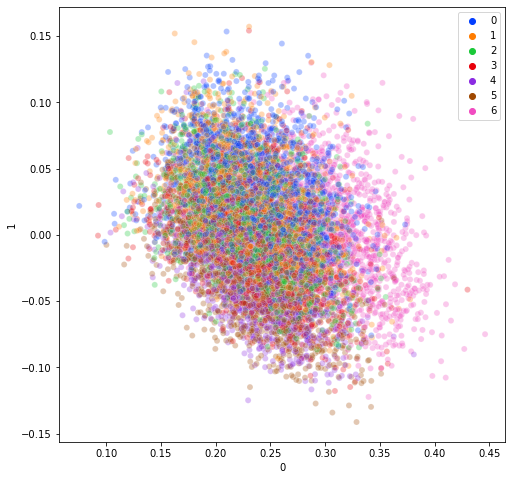

In [9]:
plt.figure(figsize=(8,8))

fit_df = pd.DataFrame(fit)
sns.scatterplot(data = fit_df, x = 0, y=1, hue=y, alpha=0.3, palette = 'bright')
plt.show()

## Feed Forward Network

In [8]:
%%time

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(10,), (20,), (30,),],
    'alpha': [0.0001, 0.05],
}

mlp_GridSearchCV = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)
mlp_GridSearchCV.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 1h 43min 8s


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10,), (20,), (30,)]},
             scoring='accuracy', verbose=5)

In [9]:
print('Best parameters found:\n', mlp_GridSearchCV.best_params_)

Best parameters found:
 {'alpha': 0.05, 'hidden_layer_sizes': (20,)}


In [10]:
means = mlp_GridSearchCV.cv_results_['mean_test_score']
stds = mlp_GridSearchCV.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp_GridSearchCV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.487 (+/-0.028) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,)}
0.493 (+/-0.024) for {'alpha': 0.0001, 'hidden_layer_sizes': (20,)}
0.492 (+/-0.031) for {'alpha': 0.0001, 'hidden_layer_sizes': (30,)}
0.509 (+/-0.020) for {'alpha': 0.05, 'hidden_layer_sizes': (10,)}
0.509 (+/-0.020) for {'alpha': 0.05, 'hidden_layer_sizes': (20,)}
0.507 (+/-0.023) for {'alpha': 0.05, 'hidden_layer_sizes': (30,)}


In [11]:
%%time

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(10,), (20,), (30,),],
    'alpha': [0.0001, 0.05],
}

mlp_GridSearchCV = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)
mlp_GridSearchCV.fit(X_train, y_train)

'i = 2, size = 30'

Wall time: 4min 59s


C:\Users\Jonathan\miniconda3\envs\jonathan\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [35]:
%%time

mlp = MLPClassifier(hidden_layer_sizes=(10,40),max_iter=1000)

mlp.fit(X_train, y_train)

test_score_NN = accuracy_score( y_test, mlp.predict(X_test) )
test_score_NN

Wall time: 1min 14s


0.45799180327868855

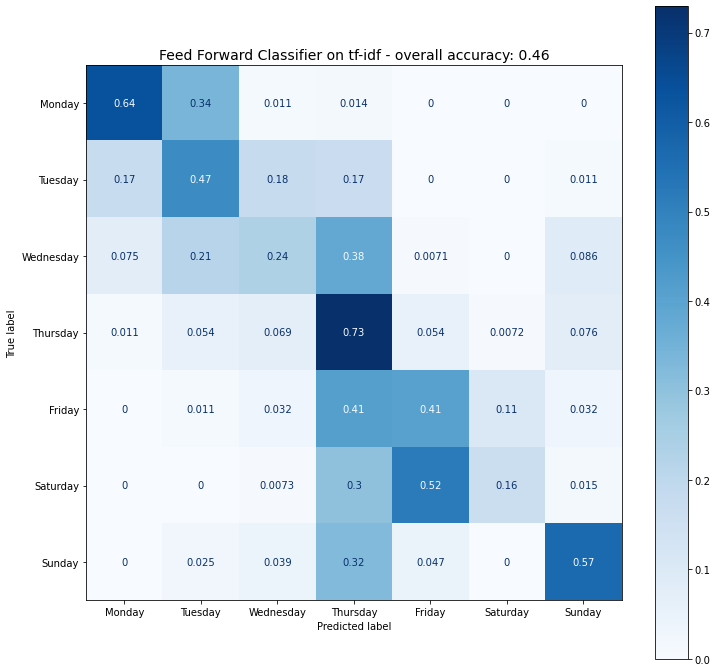

In [36]:
fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(mlp, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Feed Forward Classifier on tf-idf - overall accuracy: %.2f' % test_score_NN, fontsize=14)
plt.show()

## SVM

In [14]:
%%time

kfold = StratifiedKFold(5, shuffle = True, random_state = 514)
c_vals = [0.5, 1.0, 2.0, 5.0]

accs_linearsvm = np.zeros((5, len(c_vals)))
accs_svm = np.zeros(5)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    clear_output(wait=True)
    display(f"i = {i}")
    
    svm = SVC(kernel='linear', random_state=450)
    svm.fit(X_train_CV, y_train_CV)
    
    accs_svm[i] = accuracy_score( y_test_CV, svm.predict(X_test_CV) )
    
    for j,c in enumerate(c_vals):
        display('svm1')
        
        linearsvm = LinearSVC(C=c, random_state=450)
        linearsvm.fit(X_train_CV, y_train_CV)
        
        accs_linearsvm[i,j] = accuracy_score( y_test_CV, linearsvm.predict(X_test_CV) )
    i += 1

'i = 4'

'svm1'

'svm1'

'svm1'

'svm1'

Wall time: 11min 19s


In [27]:
accs_svm

array([0.50160154, 0.53555413, 0.53235106, 0.53042921, 0.52786675])

In [28]:
accs_linearsvm

array([[0.495836  , 0.49391416, 0.48942985, 0.4830237 ],
       [0.51057015, 0.50800769, 0.504164  , 0.50608584],
       [0.51441384, 0.51249199, 0.50992953, 0.50480461],
       [0.5169763 , 0.51121076, 0.5086483 , 0.50672646],
       [0.50288277, 0.49519539, 0.49071108, 0.48494555]])

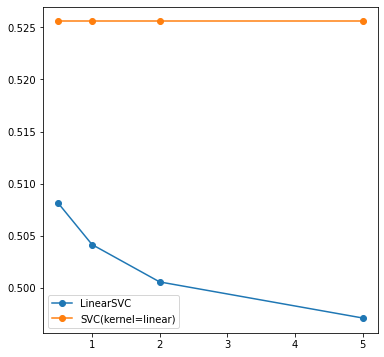

In [15]:
plt.figure(figsize=(6,6))
plt.plot(c_vals, np.mean(accs_linearsvm, axis=0), 'o-', label='LinearSVC')
plt.plot(c_vals, [np.mean(accs_svm, axis=0) for c in c_vals], 'o-', label='SVC(kernel=linear)')
plt.legend()
plt.show()

In [16]:
svm = SVC(kernel='linear', random_state=450)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=450)

In [17]:
test_score_svm = accuracy_score( y_test, svm.predict(X_test) )

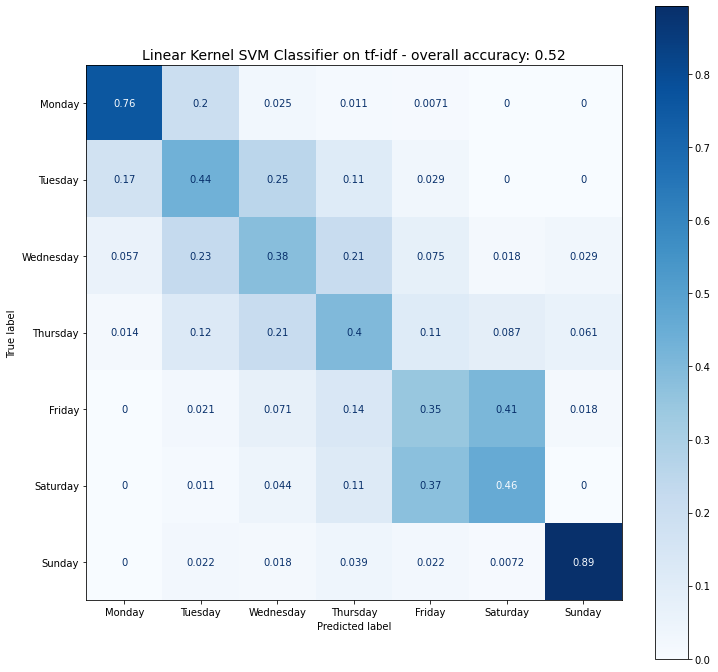

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(svm, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Linear Kernel SVM Classifier on tf-idf - overall accuracy: %.2f' % test_score_svm, fontsize=14)
plt.show()

## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
kfold = StratifiedKFold(5, shuffle = True, random_state = 514)

# Maybe increase?
depths = range(1,41)

accs_rf = np.zeros((5, len(depths)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    for j,d in enumerate(depths):
        clear_output(wait=True)
        display(f'i = {i}, depth = {d}')
        
        forest_clf = RandomForestClassifier(max_depth = d, random_state=514)
        forest_clf.fit(X_train_CV, y_train_CV)
        
        accs_rf[i,j] = accuracy_score( y_test_CV, forest_clf.predict(X_test_CV) )
    
    i += 1

'i = 4, depth = 40'

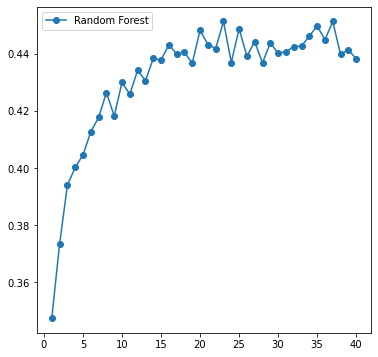

In [21]:
plt.figure(figsize=(6,6))
plt.plot(depths, np.mean(accs_rf, axis=0), 'o-', label='Random Forest')
plt.legend()
plt.show()

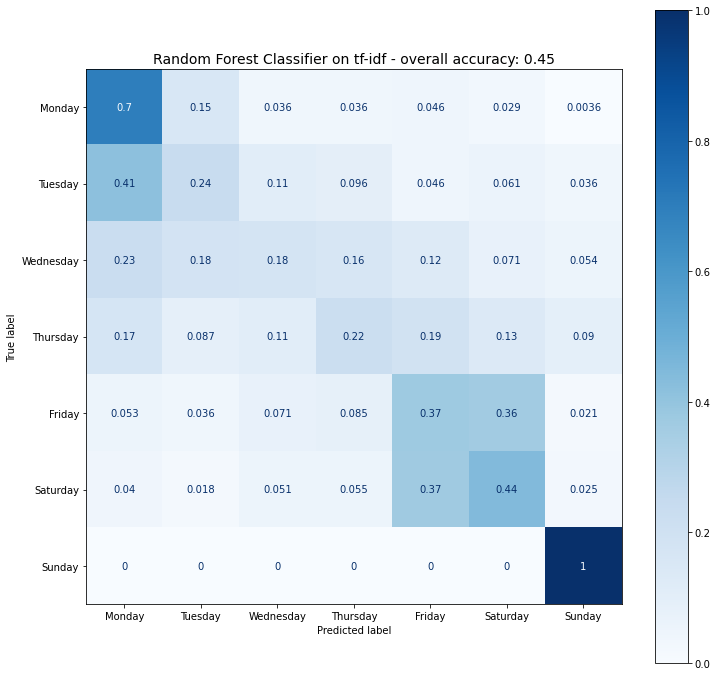

In [31]:
forest_clf = RandomForestClassifier(max_depth = 22, random_state=514)
forest_clf.fit(X_train, y_train)
test_score_rf = accuracy_score( y_test, forest_clf.predict(X_test) )

fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(forest_clf, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Random Forest Classifier on tf-idf - overall accuracy: %.2f' % test_score_rf, fontsize=14)
plt.show()

## Boosted Decision Tree

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
%%time

depths = range(1, 11)
estimators = range(1,16)
learning_rate = 0.5

accs_boost = np.zeros((len(estimators), len(depths)))

for i, n in enumerate(estimators):
    for j, d in enumerate(depths):
        clear_output(wait=True)
        display(f'estimator = {n} depth = {d}')
        
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d),
                    n_estimators = n,
                    algorithm="SAMME.R",
                    learning_rate = learning_rate
                                    )
        
        ada_clf.fit(X_train, y_train)
        accs_boost[i,j] = accuracy_score( y_test, ada_clf.predict(X_test) )

'estimator = 15 depth = 10'

Wall time: 32min 2s


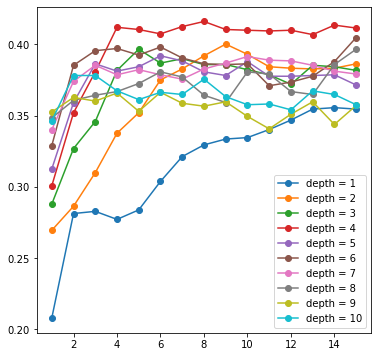

In [25]:
plt.figure(figsize=(6,6))
for d in depths:
    plt.plot(estimators, accs_boost[:,d-1], 'o-', label=f'depth = {d}')
plt.legend()
plt.show()

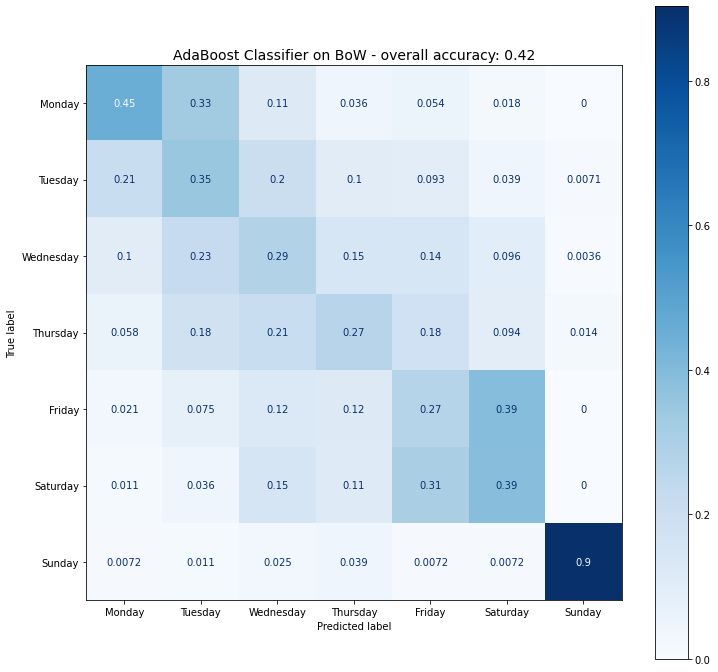

In [32]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                    n_estimators = 8,
                    algorithm="SAMME.R",
                    learning_rate = learning_rate
                                    )
ada_clf.fit(X_train, y_train)
test_score_boost = accuracy_score( y_test, ada_clf.predict(X_test) )

fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(ada_clf, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('AdaBoost Classifier on BoW - overall accuracy: %.2f' % test_score_boost, fontsize=14)
plt.show()

In [ ]:
tfidf_test_scores = {'NN': test_score_NN,
                    'SVM' : test_score_svm,
                     'Random Forest': test_score_rf,
                     'AdaBoost': test_score_boost}

random_guess = 1/7

plt.